In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


merged = pd.read_csv(r"soil_moisture_merged.csv")

print(f"Shape of merged dataset: {merged.shape}")
merged.head()

Shape of merged dataset: (2643, 18)


,AEZ_NAME,week_start,sm_surface,VV,VH,NDVI,LST,Rainfall_7d,Rainfall_7d_lag,ET,LAI,NDWI,NDMI,Temp_7d,Temp_7d_lagged,landcover,elevation,slope
0,Active Tista Floodplain,2022-01-01,0.159142,-5.761691,-13.478774,0.5488,22.31,3.705716,2.430984,8.2,0.6,0.041381,0.261766,17.507983,17.870370,40,33,1.386612
1,Tista Meander Floodplain,2022-01-01,0.152997,-7.386647,-16.112829,0.4492,23.41,4.648317,0.000000,7.5,0.6,-0.025512,0.127510,17.625635,17.970898,40,30,2.963912
2,Karatoya-Bangali Floodplain,2022-01-01,0.101049,-9.252055,-16.693300,0.4091,23.61,0.000000,0.000000,10.5,0.6,0.064735,0.241161,17.894887,18.837795,10,17,0.927410
3,Lower Atrai Basin,2022-01-01,0.107364,-9.480288,-18.177580,0.2117,23.75,6.558670,0.000000,10.5,0.2,0.022280,0.228830,17.792813,18.636809,40,13,1.378362
4,Active Brahmaputra-Jamuna Floodplain,2022-01-01,0.100783,-8.074512,-16.009851,0.4884,23.81,4.167820,2.591343,8.0,0.6,0.108474,0.320618,18.043685,18.809614,40,18,2.044861


### Random Forest

In [2]:
print("\n-9999/Missing values:")
print((merged == -9999).sum())


-9999/Missing values:
AEZ_NAME             0
week_start           0
sm_surface           0
VV                   0
VH                   0
NDVI               145
LST                  0
Rainfall_7d          0
Rainfall_7d_lag      0
ET                   0
LAI                  0
NDWI                 0
NDMI                 0
Temp_7d              0
Temp_7d_lagged       0
landcover            0
elevation            0
slope                0
dtype: int64


In [3]:
# Missing value calculation
merged_rf = merged.copy()

# NDVI median imputation
ndvi_median = merged_rf['NDVI'].median()
merged_rf['NDVI'] = merged_rf['NDVI'].fillna(ndvi_median)

print(f"NDVI missing filled with median: {ndvi_median:.4f}")

NDVI missing filled with median: 0.5755


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##### RF with all features 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

features_rf = merged_rf.columns.difference(['sm_surface', 'AEZ_NAME', 'week_start'])

X_rf = merged_rf[features_rf]
y_rf = merged_rf['sm_surface']

# 80/20 split
X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size=0.2, random_state=42, shuffle=True)

# simple forest
model_rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)

model_rf.fit(X_train_rf, y_train_rf)

# predict
y_pred_rf = model_rf.predict(X_test_rf)

# evaluation
rmse_rf = np.sqrt(mean_squared_error(y_test_rf, y_pred_rf))
mae_rf = mean_absolute_error(y_test_rf, y_pred_rf)
r2_rf = r2_score(y_test_rf, y_pred_rf)

print(f"Random Forest RMSE: {rmse_rf:.3f}")
print(f"Random Forest MAE: {mae_rf:.3f}")
print(f"Random Forest R²: {r2_rf:.2f}")

Random Forest RMSE: 0.044
Random Forest MAE: 0.033
Random Forest R²: 0.83


#### SHAP analysis

In [6]:
import shap
explainer_rf = shap.TreeExplainer(model_rf)
shap_values_rf = explainer_rf.shap_values(X_test_rf)

C:\Users\Admin\AppData\Local\Temp\ipykernel_10200\866381647.py:13: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


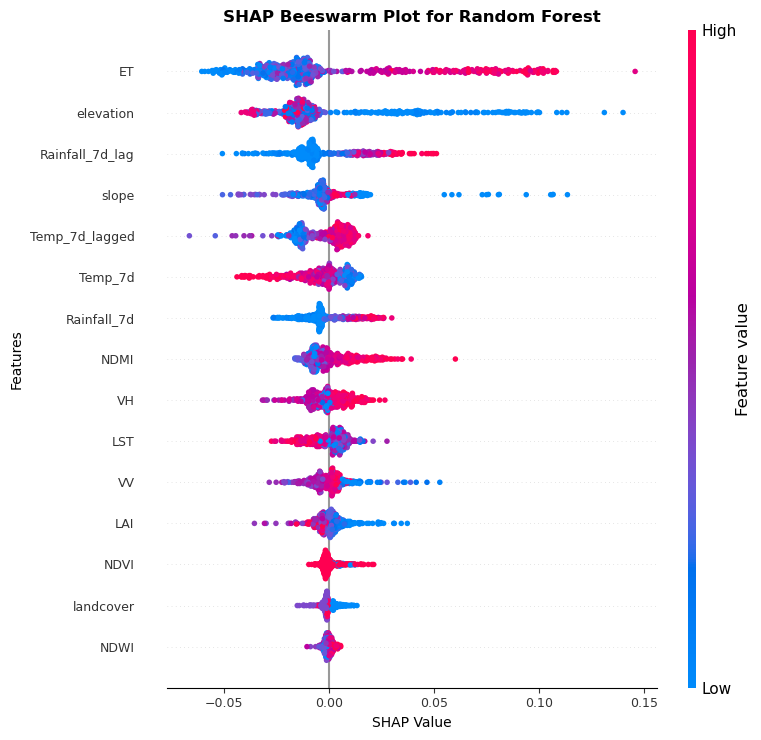

In [ ]:
# SHAP summary plot (beeswarm)
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_rf, X_test_rf, plot_type="dot", show=False)

plt.title('SHAP Beeswarm Plot for Random Forest', fontsize=12, fontweight='bold')
plt.xlabel('SHAP Value', fontsize=10)
plt.ylabel('Features', fontsize=10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=9)


plt.tight_layout()
plt.savefig('02.Shap_beeswarm_plot_rf_sorted.png', dpi=600)

plt.show()

In [ ]:
# mean absolute SHAP values
mean_shap = np.abs(shap_values_rf).mean(axis=0)
shap_df = pd.DataFrame({
    'feature': features_rf,
    'mean_abs_shap': mean_shap
}).sort_values(by='mean_abs_shap', ascending=False)

print("\nMean Absolute SHAP Values (magnitude):\n")
for _, row in shap_df.iterrows():
    print(f"{row['feature']:<20s} : {row['mean_abs_shap']:.4f}")



Mean Absolute SHAP Values (magnitude):

ET                   : 0.0351
elevation            : 0.0254
Rainfall_7d_lag      : 0.0144
slope                : 0.0095
Temp_7d_lagged       : 0.0093
Temp_7d              : 0.0091
Rainfall_7d          : 0.0086
NDMI                 : 0.0080
VH                   : 0.0067
LST                  : 0.0065
VV                   : 0.0059
LAI                  : 0.0047
NDVI                 : 0.0026
landcover            : 0.0026
NDWI                 : 0.0014


#### RF with top 5 features

In [9]:
# RF Model 2
features_rf_5 = [
    'ET',
    'elevation',
    'Rainfall_7d_lag',
    'slope',
    'Temp_7d_lagged'
]

X_rf_5 = merged_rf[features_rf_5]
y_rf_5 = merged_rf['sm_surface']

# split
X_train_rf_5, X_test_rf_5, y_train_rf_5, y_test_rf_5 = train_test_split(
    X_rf_5, y_rf_5, test_size=0.2, random_state=42, shuffle=True
)

# model
model_rf_5 = RandomForestRegressor(
    n_estimators=200,
    random_state=42
)
model_rf_5.fit(X_train_rf_5, y_train_rf_5)

# predict
y_pred_rf_5 = model_rf_5.predict(X_test_rf_5)

# metrics
rmse_rf_5 = np.sqrt(mean_squared_error(y_test_rf_5, y_pred_rf_5))
mae_rf_5 = mean_absolute_error(y_test_rf_5, y_pred_rf_5)
r2_rf_5 = r2_score(y_test_rf_5, y_pred_rf_5)

print("== RF Model 2 (5 features) ==")
print(f"RMSE: {rmse_rf_5:.3f}")
print(f"MAE : {mae_rf_5:.3f}")
print(f"R²  : {r2_rf_5:.2f}")

== RF Model 2 (5 features) ==
RMSE: 0.055
MAE : 0.041
R²  : 0.74


#### LightGBM

In [10]:
merged_clean = merged_rf

In [ ]:
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation


# features 
features_lgb_all = merged_clean.columns.difference(['sm_surface', 'AEZ_NAME', 'week_start'])
X_lgb_all = merged_clean[features_lgb_all]
y_lgb_all = merged_clean['sm_surface']

# split
X_train_lgb_all, X_test_lgb_all, y_train_lgb_all, y_test_lgb_all = train_test_split(
    X_lgb_all, y_lgb_all, test_size=0.2, random_state=42, shuffle=True
)

# dataset
train_data_all = lgb.Dataset(X_train_lgb_all, label=y_train_lgb_all)
test_data_all = lgb.Dataset(X_test_lgb_all, label=y_test_lgb_all, reference=train_data_all)

# params
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'verbosity': -1,
    'random_state': 42
}

# train
callbacks = [
    early_stopping(stopping_rounds=20)]

model_lgb_all = lgb.train(
    params,
    train_data_all,
    num_boost_round=200,
    valid_sets=[test_data_all],
    callbacks=callbacks
)

# predict
y_pred_lgb_all = model_lgb_all.predict(X_test_lgb_all, num_iteration=model_lgb_all.best_iteration)

# evaluation
rmse_lgb = np.sqrt(mean_squared_error(y_test_lgb_all, y_pred_lgb_all))
mae_lgb = mean_absolute_error(y_test_lgb_all, y_pred_lgb_all)
r2_lgb = r2_score(y_test_lgb_all, y_pred_lgb_all)

print("== LightGBM ==")
print(f"RMSE: {rmse_lgb:.3f}")
print(f"MAE : {mae_lgb:.3f}")
print(f"R²  : {r2_lgb:.2f}")

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[187]	valid_0's rmse: 0.0421101
== LightGBM ==
RMSE: 0.042
MAE : 0.031
R²  : 0.85


In [12]:
# Drop rows with missing target
merged_clean = merged.dropna(subset=['sm_surface'])

#### Support Vector Regressor
Best params: {'C': 1, 'epsilon': 0.01, 'gamma': 0.1} from GridSearchCV

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# define features 
features_svr = merged_clean.columns.difference(['sm_surface', 'AEZ_NAME', 'week_start'])
X_svr = merged_clean[features_svr]
y_svr = merged_clean['sm_surface']

# split
X_train_svr, X_test_svr, y_train_svr, y_test_svr = train_test_split(
    X_svr, y_svr, test_size=0.2, random_state=42, shuffle=True
)

# scale
scaler_svr = StandardScaler()
X_train_svr_scaled = scaler_svr.fit_transform(X_train_svr)
X_test_svr_scaled = scaler_svr.transform(X_test_svr)

# best parameters from randomized search
best_C = 1
best_epsilon = 0.01
best_gamma = 0.1

# final SVR
model_svr_final = SVR(
    kernel='rbf',
    C=best_C,
    epsilon=best_epsilon,
    gamma=best_gamma
)

# fit
model_svr_final.fit(X_train_svr_scaled, y_train_svr)

# predict
y_pred_svr_final = model_svr_final.predict(X_test_svr_scaled)

# evaluation
rmse_svr_final = np.sqrt(mean_squared_error(y_test_svr, y_pred_svr_final))
mae_svr_final = mean_absolute_error(y_test_svr, y_pred_svr_final)
r2_svr_final = r2_score(y_test_svr, y_pred_svr_final)

print("== SVR ==")
print(f"RMSE: {rmse_svr_final:.3f}")
print(f"MAE : {mae_svr_final:.3f}")
print(f"R²  : {r2_svr_final:.2f}")

== SVR ==
RMSE: 0.052
MAE : 0.037
R²  : 0.77


#### ANN
Best hyperparameters found:
{'num_layers': 2, 'units_0': 32, 'dropout_0': 0.1, 'units_1': 64, 'dropout_1': 0.4, 'learning_rate': 0.001}

In [14]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# features
features_ann = [
    'VV', 'VH', 'NDVI', 'LST', 'Rainfall_7d', 'Rainfall_7d_lag',
    'ET', 'LAI', 'NDWI', 'NDMI', 'Temp_7d', 'Temp_7d_lagged',
    'landcover', 'elevation', 'slope'
]
X_ann = merged_clean[features_ann]
y_ann = merged_clean['sm_surface']

# split
X_train_ann, X_test_ann, y_train_ann, y_test_ann = train_test_split(
    X_ann, y_ann, test_size=0.2, random_state=42
)

# scaling
scaler_ann = StandardScaler()
X_train_ann_scaled = scaler_ann.fit_transform(X_train_ann)
X_test_ann_scaled = scaler_ann.transform(X_test_ann)

# ANN model
model_ann= models.Sequential([
    layers.Input(shape=(X_train_ann_scaled.shape[1],)),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.1),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='linear')
])

model_ann.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mae']
)

early_stop = callbacks.EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

history = model_ann.fit(
    X_train_ann_scaled,
    y_train_ann,
    validation_split=0.2,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    verbose=0
)

# predict
y_pred_ann = model_ann.predict(X_test_ann_scaled).flatten()

# evaluation
rmse_ann = np.sqrt(mean_squared_error(y_test_ann, y_pred_ann))
mae_ann = mean_absolute_error(y_test_ann, y_pred_ann)
r2_ann = r2_score(y_test_ann, y_pred_ann)

print("== Final Tuned ANN ==")
print(f"RMSE: {rmse_ann:.3f}")
print(f"MAE : {mae_ann:.3f}")
print(f"R²  : {r2_ann:.2f}")

== Final Tuned ANN ==
RMSE: 0.054
MAE : 0.039
R²  : 0.75
